# Tutorial – Data Analysis of Mobility Behaviour Data

---
### September 18, 2019

---
---




# Istruction:

- To be able to work on this tutorial you need to **create your own copy of this notebook**:
  - File --> Save a copy in Drive...
  >![copy notebook](https://mattemanca.files.wordpress.com/2019/08/colab_copy.png)

- Open your own copy of the notebook and work on it.

## Goal:

The knowledge of the user preferences, behaviours and needs while traveling is a crucial aspect for administrators, travel companies, and travel related decision makers in general. It allows to study which are the main factors that influence the travel option choice, the time spent for travel preparation and travelling as well as the value proposition of the travel time.


Notice that the findings presented in this tutorial are not exhaustive and reliable to describe insights on Europeans’s perception and use of travel time since they are based only on a reduced 1-day sample.

**The main goal of the Tutorial is to provide an introduction about methods and tools that can be used to analyze mobility behaviour data.** 
The tutorial is a pratical (hands-on) session, where attendees can follow and work on a case study, related to the MoTiV project. Some of the main points we will focus are:
- Expolartory Data Analysis of the dataset;
- Example of outlier detection;
- Transport mode share;
- Worthwhileness satisfaction;
- Factors influencing user trips.


## Dataset description
The analyzed dataset contains a subset of data collected through the woorti app (iOS version - https://colab.research.google.com/drive/17RewF7cjd3jMCllHAt0vVMaxC2YikphL#scrollTo=i8EetPpa-eQp&line=2&uniqifier=1 and android version - https://play.google.com/store/apps/details?id=inesc_id.pt.motivandroid&hl=en_US ).

The dataset is composed of:

- **A set of legs:** a leg is a part of a journey (trip) and is described by the following variables:
  - *tripid*: ID of the trip to which the leg belong;
  - *legid*: unique identifier (ID) of the leg;
  - *class*: this variables contain the value `Leg` when the corresponding leg is a movement and the value `waitingTime` when it is a transfer;
  - *averageSpeed*: average speed of the leg in Km/h;
  - *correctedModeOfTransport*: Code of the corrected mode of transport used during the leg;
  - *legDistance*: distance in meters of the leg;
  - *startDate*: timestamp of the leg's start date and time;
  - *endDate*: timestamp of the leg's end date and time;
  - *wastedTime*: a score from 1 to 5 indicating if the leg was a waste of time (score 1) or if it was worthwhile (score 5).

- **A set of users:** it contains information about the users that perform the trips. Specifically, for each user it contains the following data:
  - userid: ID of the user;
  - country: country of the user;
  - gender: gender of the user;
  - labourStatus: user employment.

- **A set of trip-user associations:** it contains the associations between trips and users and is composed by the following attributes:  
    - *tripid:* ID of the trip;
    - *userid:* ID of the user;

- **A set of Experience factors:** Experience factors are factors associated to each leg that can affect positively or negatively user trips. Each factor is described by the following attributes:

  - *tripid:* ID of the trip to which the factor refer to;
  - *legid:* ID of the leg to which the factor refer to;
  - *factor:*: string indicating the name of the factor;
  - *minus:* it has value `True` if the factor affect negatively the user leg, `False` otherwise;
  - *plus:* it has value `True` if the factor affect positively the user leg, `False` otherwise.
  				
The analysed legs (and related data like the Experience Factors) have been collected during the day 07 of June, 2019 while other data like the trip-user associations (we will use to identify active users) are related to a wider period.

## Tools 
Our data analysis will be performed using the **Python** language. The main used libraries will be:

- [Pandas](https://pandas.pydata.org): a library providing high-performance, easy-to-use data structures and data analysis tools;
- [seaborn](https://seaborn.pydata.org): a Python data visualization library based on matplotlib.

In the respective links (above) you can also find instructions for installations.
Other common libraries will be used to perform data pre-processing and analysis.

## Load data

### Import libraries

In [0]:
import io # To work with with stream (files)
import requests # library to make http requests

import pandas as pd #pandas library for data structure and data manipulation

# libraries to work with dates and time
import time 
from datetime import date, datetime
import calendar

#libraries to plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

#used to supress warnings. Warning s may be usefull, in this case
# we want to supress them just for visualization matter
import warnings





### Inizialize global variables and settings

In [0]:
# table visualization. Show all columns (with a maximum of 500) in the pandas 
# dataframes
pd.set_option('display.max_columns', 500)

#distance plot - titles in plots
rcParams['axes.titlepad'] = 45

# Font size for the plots
rcParams['font.size'] = 16


# display only 2 decimal digits in pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# supress warnings
warnings.filterwarnings('ignore')

# plot inline in the notebook
%matplotlib inline


### Read the dataset:

- legs
- users
- user-trip associations
- factors


and show the dimensionality of the data.

The data are stored in `pickle` format, i.e., the python’s serialization format and their URL are provided.

In pandas [`DataFrame.shape`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html) Return a tuple representing the dimensionality of the DataFrame.

**To load the data, run the following code.**

In [0]:
# URLs of the files containing the data
legs_url="https://www.dropbox.com/s/8uxafqwzowqtdtj/original_all_legs1.pkl?dl=1"          
trip_user_url="https://www.dropbox.com/s/m4vaofgnhwhp04p/trips_users_df.pkl?dl=1"
users_url="https://www.dropbox.com/s/dx1obv166i3x7qj/users_df.pkl?dl=1"
factors_url="https://www.dropbox.com/s/dnz7l1f0s0f9xun/all_factors1.pkl?dl=1"
             




# create Pandas' dataframes
s=requests.get(legs_url).content
legs_df=pd.read_pickle(io.BytesIO(s), compression=None)

s=requests.get(trip_user_url).content
trip_user_df=pd.read_pickle(io.BytesIO(s), compression=None)

s=requests.get(users_url).content
users_df=pd.read_pickle(io.BytesIO(s), compression=None)

s=requests.get(factors_url).content
factors_df=pd.read_pickle(io.BytesIO(s), compression=None)


# Check dimensionality
print('Shape of leg dataset',legs_df.shape)
print('Shape of user-trips  dataset',trip_user_df.shape)
print('Shape of users dataset',users_df.shape)
print('Shape of factors dataset',factors_df.shape)


Shape of leg dataset (792, 9)
Shape of user-trips  dataset (10461, 2)
Shape of users dataset (476, 4)
Shape of factors dataset (1237, 5)


#### Explore the legs dataset
Use the function [`DataFrame.head(self, n=5)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html)
Return the first `n` rows.

This function returns the first n (by default n=5) rows for the object. It is useful for quickly testing if your object has the right type of data in it.

It also exists the corresponding `DataFrame.tail(self, n=5)` function to explore the last n rows.


In [0]:
legs_df.head(3)

,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime
1,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2
0,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1
1,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1


#### Explore the user dataset

In [0]:
users_df.head(3)

,userid,country,gender,labourStatus
1,x0Ck3t0b78erBIwZSzq6GwGDQzb2,PRT,Male,-
2,ABoCGWCiLpdo16uvOfjohJsnaT72,PRT,Male,Student
6,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,SVK,Male,-


#### Explore the trip-user association dataset

In [0]:
trip_user_df.head(3)

,tripid,userid
3186,#32:1188,L93gcTzlEeMm8GwXiSK3TDEsvJJ3
3187,#33:1173,aSzcZ3yAjpTjLKUTCn5nuOTjqKh2
3188,#30:1229,OQVdocMUTjOow8qvnbBqBZ6iynn1


## [Selecting Subsets of Data in Pandas](https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c)

Create a toy dataframe to explore the functions available to select and slice part of pandas dataframe.

In [0]:
toy_df = users_df.head(10)
toy_df

,userid,country,gender,labourStatus
1,x0Ck3t0b78erBIwZSzq6GwGDQzb2,PRT,Male,-
2,ABoCGWCiLpdo16uvOfjohJsnaT72,PRT,Male,Student
6,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,SVK,Male,-
8,pKGhRs0mGJgJuATlf6mIKxgkhfK2,SVK,Male,Employed full Time
10,tbfCRzSJnsa7aiwGCRmgby0GR1G3,PRT,Male,-
30,qEsHejZtOlOPCEZxaIPJ3lB1xn12,PRT,Male,-
31,22mkWBTU8xbsIYBxDAF5gKj0agI2,BEL,Female,-
32,SvRLhh4zouPyASLsEaI33vSsg4m1,FIN,Male,-
34,yqcd26PfXIRM8PZEToVtfkcQNdg2,SVK,Male,-
35,7JWFtgILPmUEgFmnaDol71lyJ1p1,SVK,Male,Employed full Time


In [0]:
index = toy_df.index
columns = toy_df.columns
values = toy_df.values

print('Indexes: ', index, '\n')
print('COlumns: ',columns, '\n')
print('Values:\n',values)

Indexes:  Int64Index([1, 2, 6, 8, 10, 30, 31, 32, 34, 35], dtype='int64') 

COlumns:  Index(['userid', 'country', 'gender', 'labourStatus'], dtype='object') 

Values:
 [['x0Ck3t0b78erBIwZSzq6GwGDQzb2' 'PRT' 'Male' '-']
 ['ABoCGWCiLpdo16uvOfjohJsnaT72' 'PRT' 'Male' 'Student']
 ['pRPAYm5TSmN8I0mUc0LuJdR1zCK2' 'SVK' 'Male' '-']
 ['pKGhRs0mGJgJuATlf6mIKxgkhfK2' 'SVK' 'Male' 'Employed full Time']
 ['tbfCRzSJnsa7aiwGCRmgby0GR1G3' 'PRT' 'Male' '-']
 ['qEsHejZtOlOPCEZxaIPJ3lB1xn12' 'PRT' 'Male' '-']
 ['22mkWBTU8xbsIYBxDAF5gKj0agI2' 'BEL' 'Female' '-']
 ['SvRLhh4zouPyASLsEaI33vSsg4m1' 'FIN' 'Male' '-']
 ['yqcd26PfXIRM8PZEToVtfkcQNdg2' 'SVK' 'Male' '-']
 ['7JWFtgILPmUEgFmnaDol71lyJ1p1' 'SVK' 'Male' 'Employed full Time']]


### Selecting multiple columns with just the indexing operator

- Its primary purpose is to select columns by the column names
- Select a single column as a Series by passing the column name directly to it: `df['col_name']`
- Select multiple columns as a DataFrame by passing a list to it: `df[['col_name1', 'col_name2']]`

In [0]:
# Select multiple columns: returns a Dataframe
toy_df[['userid','country']]

,userid,country
1,x0Ck3t0b78erBIwZSzq6GwGDQzb2,PRT
2,ABoCGWCiLpdo16uvOfjohJsnaT72,PRT
6,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,SVK
8,pKGhRs0mGJgJuATlf6mIKxgkhfK2,SVK
10,tbfCRzSJnsa7aiwGCRmgby0GR1G3,PRT
30,qEsHejZtOlOPCEZxaIPJ3lB1xn12,PRT
31,22mkWBTU8xbsIYBxDAF5gKj0agI2,BEL
32,SvRLhh4zouPyASLsEaI33vSsg4m1,FIN
34,yqcd26PfXIRM8PZEToVtfkcQNdg2,SVK
35,7JWFtgILPmUEgFmnaDol71lyJ1p1,SVK


In [0]:
# Select one column: return a series
toy_df['userid']

1     x0Ck3t0b78erBIwZSzq6GwGDQzb2
2     ABoCGWCiLpdo16uvOfjohJsnaT72
6     pRPAYm5TSmN8I0mUc0LuJdR1zCK2
8     pKGhRs0mGJgJuATlf6mIKxgkhfK2
10    tbfCRzSJnsa7aiwGCRmgby0GR1G3
30    qEsHejZtOlOPCEZxaIPJ3lB1xn12
31    22mkWBTU8xbsIYBxDAF5gKj0agI2
32    SvRLhh4zouPyASLsEaI33vSsg4m1
34    yqcd26PfXIRM8PZEToVtfkcQNdg2
35    7JWFtgILPmUEgFmnaDol71lyJ1p1
Name: userid, dtype: object

### `.loc` Indexer

It can select subsets of rows or columns. It can also simultaneously select subsets of rows and columns. Most importantly, it only selects data by the **LABEL** of the rows and columns.

In [0]:
toy_df.loc[[2, 31, 32], ['userid', 'gender']]

,userid,gender
2,ABoCGWCiLpdo16uvOfjohJsnaT72,Male
31,22mkWBTU8xbsIYBxDAF5gKj0agI2,Female
32,SvRLhh4zouPyASLsEaI33vSsg4m1,Male


**Note:**  2, 31, 32 are interpreted as labels of the index. This use is not an integer position along the index.

We can also select the row by means of specific **Conditions**. See example below:

In [0]:
toy_df.loc[toy_df.userid=='ABoCGWCiLpdo16uvOfjohJsnaT72', ['userid', 'gender']]

,userid,gender
2,ABoCGWCiLpdo16uvOfjohJsnaT72,Male


### `.iloc` Indexer

The .iloc indexer is very similar to .loc but only uses integer locations to make its selections.



In [0]:
toy_df.iloc[2] # it retrieves the second row

userid          pRPAYm5TSmN8I0mUc0LuJdR1zCK2
country                                  SVK
gender                                  Male
labourStatus                               -
Name: 6, dtype: object

In [0]:
toy_df.iloc[[1, 3]]  # it retrieves first and third rows
# remember, don't do df.iloc[1, 3]

,userid,country,gender,labourStatus
2,ABoCGWCiLpdo16uvOfjohJsnaT72,PRT,Male,Student
8,pKGhRs0mGJgJuATlf6mIKxgkhfK2,SVK,Male,Employed full Time


In [0]:
#Select two rows and two columns:
toy_df.iloc[[2,3], [0, 3]]

,userid,labourStatus
6,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,-
8,pKGhRs0mGJgJuATlf6mIKxgkhfK2,Employed full Time


In [0]:
#Select two rows and columns from 0 to 3:
toy_df.iloc[[2,3], 0:3]

,userid,country,gender
6,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,SVK,Male
8,pKGhRs0mGJgJuATlf6mIKxgkhfK2,SVK,Male


## Usefull Functions

### [`DataFrame.describe(self, percentiles=None, include=None, exclude=None)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html). 

Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [0]:
legs_df.describe()

,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime
count,616.00,616.00,616.00,792.00,792.00,792.00
mean,18.64,8.91,10862.62,1559910613585.42,1559911457932.85,0.68
std,43.47,5.21,48933.19,16979818.50,17053437.34,2.35
min,0.00,1.00,0.00,1559876476234.00,1559876968789.00,-1.00
25%,3.23,7.00,224.90,1559894050940.50,1559894810575.25,-1.00
50%,6.19,7.00,999.00,1559911748085.50,1559912610640.50,-1.00
75%,19.61,9.00,4605.30,1559924131840.75,1559925315824.50,3.00
max,657.42,33.00,1001421.00,1559951566656.00,1559952336754.00,6.00


In [0]:
toy_df.describe()

,userid,country,gender,labourStatus
count,10,10,10,10
unique,10,4,2,3
top,pRPAYm5TSmN8I0mUc0LuJdR1zCK2,SVK,Male,-
freq,1,4,9,7


#### Describe a single (or a subset ) column

In [0]:
legs_df['legDistance'].describe()

count       616.00
mean      10862.62
std       48933.19
min           0.00
25%         224.90
50%         999.00
75%        4605.30
max     1001421.00
Name: legDistance, dtype: float64

### [`DataFrame.groupby(self, by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False, observed=False, **kwargs)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html#pandas.DataFrame.groupby)

A groupby operation involves some combination of splitting the object, applying a function, and combining the results. This can be used to group large amounts of data and compute operations on these groups.

In [0]:
toy_df.groupby('country').size()

country
BEL    1
FIN    1
PRT    4
SVK    4
dtype: int64

In [0]:
#group by multiple columns
toy_df.groupby(['gender', 'country']).size()

gender  country
Female  BEL        1
Male    FIN        1
        PRT        4
        SVK        4
dtype: int64

In [0]:
# To make more readeable we can transform it in a pandas dataframe

group_count = pd.DataFrame(toy_df.groupby(['gender', 'country']).size().reset_index())
group_count.columns = ['gender', 'country', 'count'] # assign name to last column 
group_count

,gender,country,count
0,Female,BEL,1
1,Male,FIN,1
2,Male,PRT,4
3,Male,SVK,4


#### groupby and aggregate by sum

In [0]:
legs_df.groupby('correctedModeOfTransport')['legDistance'].sum()

# we obtain the transport mode code and the corresponding total distance traveled

correctedModeOfTransport
1.00     177390.08
4.00      89490.68
7.00     270711.08
8.00      11354.70
9.00    2105097.60
10.00    775075.35
11.00      7007.78
12.00    102455.06
13.00      5595.00
14.00   1001421.00
15.00    130166.28
16.00     81920.00
17.00      4345.00
20.00      2989.00
22.00   1012647.00
23.00     12525.00
27.00     59417.00
28.00    353309.00
33.00    488458.00
Name: legDistance, dtype: float64

### `merge(df_left, df_righr, on=, how=)`

Two or more DataFrames may contain different kinds of information about the same entity and can be linked by some common feature/column. To join these DataFrames, pandas provides multiple functions like concat(), merge() , join(), etc. In this section, we see the `merge()` function of pandas.

In [0]:
# Create dataframe 1
dummy_data1 = {
        'id': ['1', '2', '3'],
        'Feature1': ['A', 'C', 'E']}
df1 = pd.DataFrame(dummy_data1, columns = ['id', 'Feature1'])
df1
        


,id,Feature1
0,1,A
1,2,C
2,3,E


In [0]:
# Create dataframe 1
dummy_data2 = {
        'id': ['1', '3', '2'],
        'Feature2': ['L', 'N', 'P']}
df2 = pd.DataFrame(dummy_data2, columns = ['id', 'Feature2'])
df2
        


,id,Feature2
0,1,L
1,3,N
2,2,P


In [0]:
merged_df = pd.merge(df1, df2, on='id', how='left')
merged_df

,id,Feature1,Feature2
0,1,A,L
1,2,C,P
2,3,E,N


**Note:** In the above example we cannot use a concat since the order of the id values are different in the two dataframes.

The value `left` in the `how` parameter allows to use the left dataframe (in this case df1) as master dataframe and to add information from the right dataframe (df2) on it. If we do not specify `left`, a inner merge is performed.

##Data Pre-Processing

#### Remove inactive users

- Identify users that have less than 5 reported trips and remove all data associated to them from the legs and users datasets


In [0]:
# Number of trip per user
trips_x_users = trip_user_df.groupby('userid')['tripid'].size().reset_index()
trips_x_users.columns = ['userid', 'trip_count']

#filter out users with less than 5 trips
active_users = trips_x_users[trips_x_users['trip_count'] > 4]
print(active_users.shape)
active_users.head(3)

(393, 2)


,userid,trip_count
0,022aIMnu1fVUaCNx5joiMKTD9R02,35
1,08UoFnYn6SZXWKAn12orSeFBf6q1,14
2,0QxcRbIPxMYIh0ieJcq8dP7Mxsf2,48


In [0]:
#Number of active users
users_df[users_df['userid'].isin(active_users['userid'])].shape

(393, 4)

- Add the userid to each leg in the legs dataset.

In [0]:
trip_user_df.head(2)

,tripid,userid
3186,#32:1188,L93gcTzlEeMm8GwXiSK3TDEsvJJ3
3187,#33:1173,aSzcZ3yAjpTjLKUTCn5nuOTjqKh2


In [0]:
# add corresponding user to each leg
print(legs_df.shape)
legs_df = pd.merge(legs_df, trip_user_df, on='tripid', how='left')
print(legs_df.shape)
legs_df.head(3)

(792, 9)
(792, 10)


,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493


### Remove legs of inactive users

In [0]:
legs_df = legs_df[legs_df['userid'].isin(active_users['userid'])]
print(legs_df.shape)

(761, 10)


### In case there are remove duplicates them

In [0]:
print('Remove duplicates...')
legs_df = legs_df.drop_duplicates(['tripid','legid'],keep='first')
print(legs_df.shape)



Remove duplicates...
(761, 10)


- **There may be cases where the same leg is stored multiple times with different legid. Remove also these duplicates**

<!-- See example: 
- user "MKJorfXu9NQ56wyoe4kltLCFLa42"

  *  leg #22:4921
  *  leg #23:4903
 -->

The main idea is that if two legs belong to the same user and have been performed at the same moment (in addition with the same transport mode), this is the same leg erroneusly registered twice.

In [0]:
allcols = list(legs_df.columns)
print('allcols: ' , allcols)
colstoremove = ['legid','tripid', 'activitiesFactors','valueFromTrip']
colsfordup = list(set(allcols) - set(colstoremove))
print('\nWe want to check duplicates based on the following columns: ', colsfordup)

allcols:  ['tripid', 'legid', 'class', 'averageSpeed', 'correctedModeOfTransport', 'legDistance', 'startDate', 'endDate', 'wastedTime', 'userid']

We want to check duplicates based on the following columns:  ['userid', 'wastedTime', 'correctedModeOfTransport', 'class', 'averageSpeed', 'endDate', 'legDistance', 'startDate']


In [0]:

shape_before = legs_df.shape
legs_df = legs_df.drop_duplicates(colsfordup,keep='first')   
shape_after = legs_df.shape

print('Found ', shape_after[0]-shape_before[0], ' duplicates')

Found  0  duplicates


### Data transformation
 - The dates are expressed in timestamp format. It makes difficult to understand them.
 - Make date columns readable

In [0]:
legs_df['startDate_formated'] = pd.to_datetime(legs_df['startDate'],unit='ms')
legs_df['endDate_formated'] = pd.to_datetime(legs_df['endDate'],unit='ms')
legs_df.head(3)

,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2,2019-06-07 04:34:32.727,2019-06-07 05:10:08.192
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386


**Compute leg duration.**

- Use the **`getDuration(date1, date2)`** function already implmented.
- Use the **`apply`** function of pandas. It applies a function along an axis of the DataFrame.
Objects passed to the function are Series objects whose index is either the DataFrame’s index (axis=0) or the DataFrame’s columns (axis=1). 
- Create a **`lambda`** function to be used with the `apply` function. A lambda function is a small anonymous function that can take any number of arguments, but can only have one expression.

In [0]:
def getDuration(d1, d2):
    
    fmt = '%Y-%m-%d %H:%M:%S'
    d1 = datetime.strptime(str(d1)[0:19], fmt)
    d2 = datetime.strptime(str(d2)[0:19], fmt)
    duration_in_s = (d2-d1).total_seconds()     
    minutes = divmod(duration_in_s, 60)
    return minutes[0] + minutes[1]/100

  


In [0]:
legs_df['duration_min'] = legs_df.apply(lambda x: getDuration(x['startDate_formated'], x['endDate_formated']), axis=1)
legs_df.head(3)

,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2,2019-06-07 04:34:32.727,2019-06-07 05:10:08.192,35.36
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20


- To make data more interpretable now we decode the transport mode code

In [0]:
transport_mode_input_file = "https://www.dropbox.com/s/9zqxhzf8trgzfz8/transport_mode.csv?dl=1"
trasp_mode = pd.read_csv(transport_mode_input_file, sep=';')
trasp_mode.head()


,transport_code,transport_str
0,0,vehicle
1,1,bicycle
2,2,onfoot
3,3,still
4,4,unknown


In [0]:
# Use a dictionary to decode transport mode codes
trasp_mode_dict = trasp_mode.set_index('transport_code').to_dict()['transport_str']
print(trasp_mode_dict)

{0: 'vehicle', 1: 'bicycle', 2: 'onfoot', 3: 'still', 4: 'unknown', 5: 'tilting', 6: 'inexistent', 7: 'walking', 8: 'running', 9: 'car', 10: 'train', 11: 'tram', 12: 'subway', 13: 'ferry', 14: 'plane', 15: 'bus', 16: 'electricBike', 17: 'bikeSharing', 18: 'microScooter', 19: 'skate', 20: 'motorcycle', 21: 'moped', 22: 'carPassenger', 23: 'taxi', 24: 'rideHailing', 25: 'carSharing', 26: 'carpooling', 27: 'busLongDistance', 28: 'highSpeedTrain', 29: 'other', 30: 'otherPublic', 31: 'otherActive', 32: 'otherPrivate', 33: 'intercityTrain', 34: 'wheelChair', 35: 'cargoBike', 36: 'carSharingPassenger', 37: 'electricWheelchair'}


Add the transport mode in string format to the legs dataframe

In [0]:
try:
  legs_df['ModeOfTransport'] = legs_df['correctedModeOfTransport'].apply(lambda x:trasp_mode_dict[x])
except Exception as e:
  print('Error: ', e)

Error:  nan


We obtained an error since the column **correctedModeOfTransport** contain missing values. 
Moreover, it contains -1 values.
Drop legs having -1 and missing and try again to add the mode of transport in string format.

In [0]:
legs_df[['correctedModeOfTransport']] = legs_df[['correctedModeOfTransport']].fillna(value=4)
legs_df = legs_df[(legs_df['correctedModeOfTransport'] != -1 )]
try:
  legs_df['ModeOfTransport'] = legs_df['correctedModeOfTransport'].apply(lambda x:trasp_mode_dict[x])
except Exception as e:
  print('Error: ', e)
legs_df.head(3)

,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2,2019-06-07 04:34:32.727,2019-06-07 05:10:08.192,35.36,walking
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12,bus
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train


### Outliers Detection

 **Definition:** Observation which deviates so much from other observations as to arouse suspicion it was generated by a different mechanism” - *Hawkins(1980)*.


To detect (and later remove) outliers we will use the same methodology used by box plots.
A boxplot shows the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).


We will detect outliers for the **duration** and **distance** variables for each trasnport mode.


``
The best way to handle outliers depends on “domain knowledge”; that is, information about where the data come from and what they mean. And it depends on what analysis you are planning to perform.
`` [book: Think Stats Exploratory Data Analysis in Python]


>![Outliers](https://miro.medium.com/max/700/1*2c21SkzJMf3frPXPAR_gZA.png)
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51




#### Duration

- Analyze statistics for each transport mode and compute the upper bound value for the duration (expressed in minutes) as:

$up\_bound\_time = Q3 + 1.5*(IQR)$

Where

$IQR = Q3 - Q1$


In [0]:
duration_stats = legs_df.groupby('ModeOfTransport')['duration_min'].describe().reset_index()
duration_stats

,ModeOfTransport,count,mean,std,min,25%,50%,75%,max
0,bicycle,58.00,12.82,20.44,0.00,4.46,8.16,14.51,124.20
1,bikeSharing,2.00,7.77,0.60,7.35,7.56,7.77,7.99,8.20
2,bus,31.00,13.31,8.47,1.06,6.17,11.47,19.37,30.55
3,busLongDistance,1.00,57.09,nan,57.09,57.09,57.09,57.09,57.09
4,car,120.00,22.62,26.12,-4.62,7.05,14.12,28.09,151.26
5,carPassenger,28.00,30.81,38.60,1.47,9.03,18.10,31.79,180.27
6,electricBike,11.00,24.70,16.86,1.32,12.75,16.08,41.27,46.13
7,ferry,1.00,27.49,nan,27.49,27.49,27.49,27.49,27.49
8,highSpeedTrain,5.00,33.87,24.17,3.48,13.42,45.22,47.03,60.21
9,intercityTrain,3.00,95.86,81.93,47.58,48.55,49.53,120.00,190.46


In [0]:
duration_stats['up_bound_time'] = duration_stats['75%'] + 1.5*(duration_stats['75%'] - duration_stats['25%'])
duration_stats.head()

,ModeOfTransport,count,mean,std,min,25%,50%,75%,max,up_bound_time
0,bicycle,58.00,12.82,20.44,0.00,4.46,8.16,14.51,124.20,29.59
1,bikeSharing,2.00,7.77,0.60,7.35,7.56,7.77,7.99,8.20,8.62
2,bus,31.00,13.31,8.47,1.06,6.17,11.47,19.37,30.55,39.17
3,busLongDistance,1.00,57.09,nan,57.09,57.09,57.09,57.09,57.09,57.09
4,car,120.00,22.62,26.12,-4.62,7.05,14.12,28.09,151.26,59.64



#### Distance

- Analyze statistics for each transport mode and compute the upper bound value for the distance (expressed in meters) as:

$up\_bound\_dist = Q3 + 1.5*(IQR)$

Where

$IQR = Q3 - Q1$



In [0]:
distance_stats = legs_df.groupby('ModeOfTransport')['legDistance'].describe().reset_index()
distance_stats

,ModeOfTransport,count,mean,std,min,25%,50%,75%,max
0,bicycle,58.00,2658.33,5533.02,0.00,453.28,1315.50,2584.50,35163.00
1,bikeSharing,2.00,2172.50,505.58,1815.00,1993.75,2172.50,2351.25,2530.00
2,bus,31.00,4198.91,8557.60,0.00,1121.50,2417.00,4914.00,48963.00
3,busLongDistance,1.00,59417.00,nan,59417.00,59417.00,59417.00,59417.00,59417.00
4,car,120.00,17529.00,29067.35,0.00,1783.75,4642.00,16154.25,153065.00
5,carPassenger,28.00,36165.96,60228.99,20.00,2649.25,10264.00,35120.00,265102.00
6,electricBike,11.00,7219.73,5479.53,116.00,3442.50,4474.00,12748.50,15259.00
7,ferry,1.00,5595.00,nan,5595.00,5595.00,5595.00,5595.00,5595.00
8,highSpeedTrain,5.00,70661.80,91164.51,230.00,832.00,61898.00,66989.00,223360.00
9,intercityTrain,3.00,162819.33,167590.35,66047.00,66061.00,66075.00,211205.50,356336.00


In [0]:
distance_stats['up_bound_dist'] = distance_stats['75%'] + 1.5*(distance_stats['75%'] - distance_stats['25%'])
distance_stats.head()

,ModeOfTransport,count,mean,std,min,25%,50%,75%,max,up_bound_dist
0,bicycle,58.00,2658.33,5533.02,0.00,453.28,1315.50,2584.50,35163.00,5781.33
1,bikeSharing,2.00,2172.50,505.58,1815.00,1993.75,2172.50,2351.25,2530.00,2887.50
2,bus,31.00,4198.91,8557.60,0.00,1121.50,2417.00,4914.00,48963.00,10602.75
3,busLongDistance,1.00,59417.00,nan,59417.00,59417.00,59417.00,59417.00,59417.00,59417.00
4,car,120.00,17529.00,29067.35,0.00,1783.75,4642.00,16154.25,153065.00,37710.00


- add max_out_time values to legs df

In [0]:
print(legs_df.shape)
legs_df = pd.merge(legs_df,duration_stats[['ModeOfTransport','up_bound_time']], on='ModeOfTransport', how='left')
print(legs_df.shape)
legs_df.head(3)

(761, 14)
(761, 15)


,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2,2019-06-07 04:34:32.727,2019-06-07 05:10:08.192,35.36,walking,19.40
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12,bus,39.17
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train,65.47


- Add max_out_dist to legs

In [0]:
print(legs_df.shape)
legs_df = pd.merge(legs_df,distance_stats[['ModeOfTransport','up_bound_dist']], on='ModeOfTransport', how='left')
print(legs_df.shape)
legs_df.head(3)

(761, 15)
(761, 16)


,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time,up_bound_dist
0,#32:3124,#23:7658,Leg,0.24,7.00,142.00,1559882072727,1559884208192,2,UNGSuZopM6SFnINR42Lh7lmAxRI2,2019-06-07 04:34:32.727,2019-06-07 05:10:08.192,35.36,walking,19.40,1540.10
1,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12,bus,39.17,10602.75
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train,65.47,53033.75


Filter out outliers:
- duration < 1or > of the computed upper bound
- distance > of the computed upper bound

In [0]:
print(legs_df.shape)
legs_df = legs_df[legs_df['duration_min'] >= 1]
legs_df = legs_df[(legs_df['legDistance'] <= legs_df['up_bound_dist']) & (legs_df['duration_min'] <= legs_df['up_bound_time'])]
print(legs_df.shape)

(761, 16)
(507, 16)


Notice that the above approach to detect outliers makes sense where the data follow a normal distribution (or at least almost normal). In this case we did not make this check. 

In cases data do not follow a normal distribution, outliers detection depends on the domain knowledge, i.e., where the data come from and what they mean. And it depends on what analysis you are planning to perform. For instance quantiles can be used to remove the n% lowest and highest values.

## Exploratory Data Analysis

### Tranport mode share

#### Travel time minutes per mode

In [0]:
transport_mode_share = legs_df.groupby('ModeOfTransport')['duration_min'].sum().reset_index().sort_values(by='duration_min', ascending=False)
transport_mode_share['frel'] = transport_mode_share['duration_min']/transport_mode_share['duration_min'].sum() *100
transport_mode_share.head()

,ModeOfTransport,duration_min,frel
4,car,1368.71,23.40
16,walking,1253.99,21.44
14,train,579.01,9.90
0,bicycle,515.16,8.81
5,carPassenger,484.90,8.29


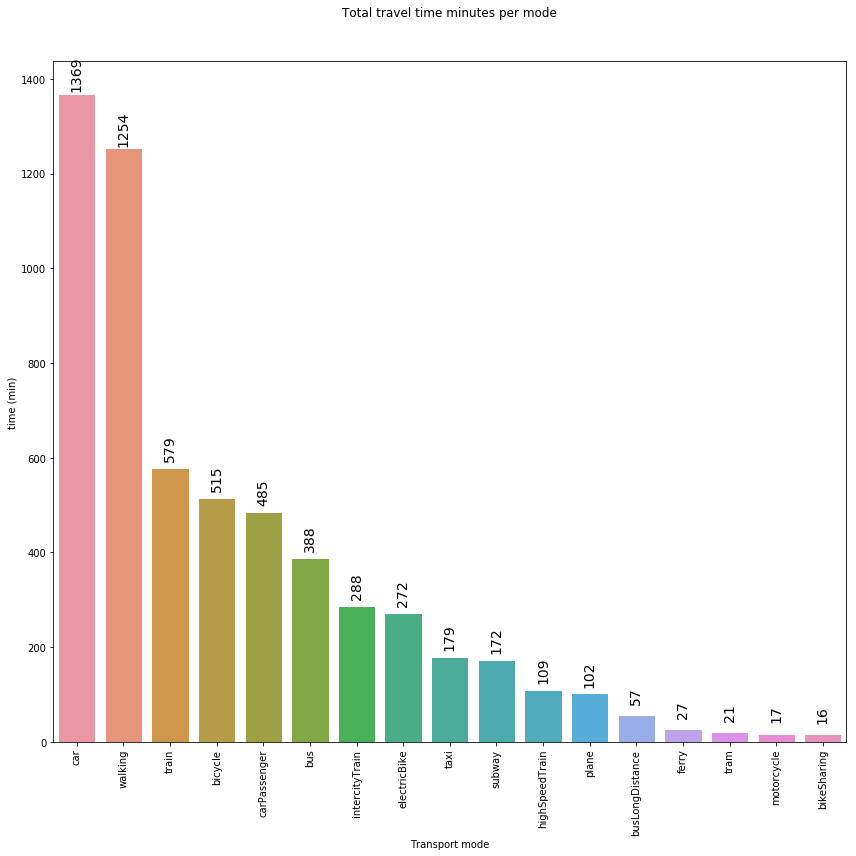

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")


g = sns.barplot(data = transport_mode_share, x="ModeOfTransport", y='duration_min').set(
    xlabel='Transport mode', 
    ylabel = 'time (min)'
)


plt.title('Total travel time minutes per mode', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

- **Group all transport modes < 1 in a unique set named "other" and all train types in "Train"
and show percentage instead of absolute values**

In [0]:
#Use apply function to replace "intercityTrain" and "highSpeedTrain" with "train" and group them together
transport_mode_share['ModeOfTransport'] = transport_mode_share.apply(lambda x: "train" if x['ModeOfTransport'] in (['intercityTrain','highSpeedTrain']) else x['ModeOfTransport'], axis=1)
transport_mode_share = transport_mode_share.groupby('ModeOfTransport').sum().reset_index().sort_values('frel', ascending=False)

#Group all trasport modes that have freq < 1
transport_mode_share['ModeOfTransport'] = transport_mode_share.apply(lambda x: x['ModeOfTransport'] if x['frel'] >= 1 else "other", axis=1)
transport_mode_share = transport_mode_share.groupby('ModeOfTransport').sum().reset_index().sort_values('frel', ascending=False)
transport_mode_share

,ModeOfTransport,duration_min,frel
2,car,1368.71,23.40
10,walking,1253.99,21.44
9,train,975.73,16.68
0,bicycle,515.16,8.81
3,carPassenger,484.90,8.29
1,bus,388.49,6.64
4,electricBike,271.66,4.64
8,taxi,178.85,3.06
7,subway,172.47,2.95
5,other,138.00,2.36


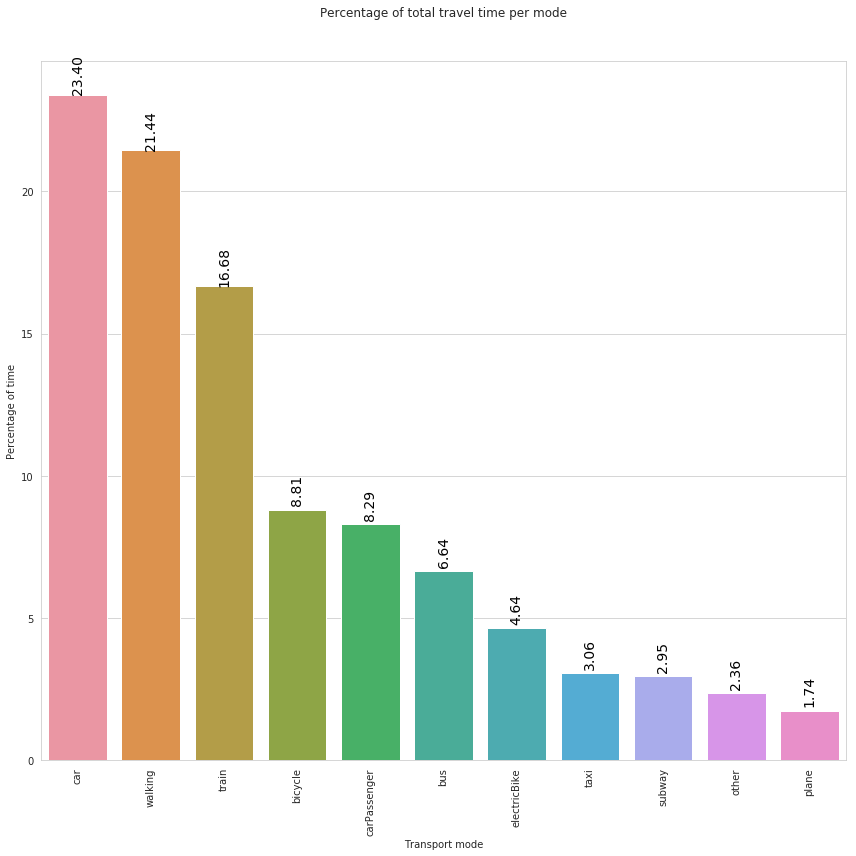

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,8

g = sns.barplot(data = transport_mode_share, x="ModeOfTransport", y='frel').set(
    xlabel='Transport mode', 
    ylabel = 'Percentage of time'
)

plt.title('Percentage of total travel time per mode', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

In the above plot we can observe that, during the analyzed 1-day period, users reported to spend more time traveling by car, walking or by train.

#### Exercise 1:
**Show the total travel distance per mode:**
- Use relative values (percentages)
- Group all transport modes < 1 in a unique set named "other" and all train types in "Train"
- Since distances are expressed in meters, transform them in km

In [0]:
# PUT YOUR CODE HERE

# transport_mode_share = ...


# merge all train types and transport modes whith low frequency (< 1). USE APPLY FUNCTION
#transport_mode_share['transportMode'] = transport_mode_share.apply(lambda x:...


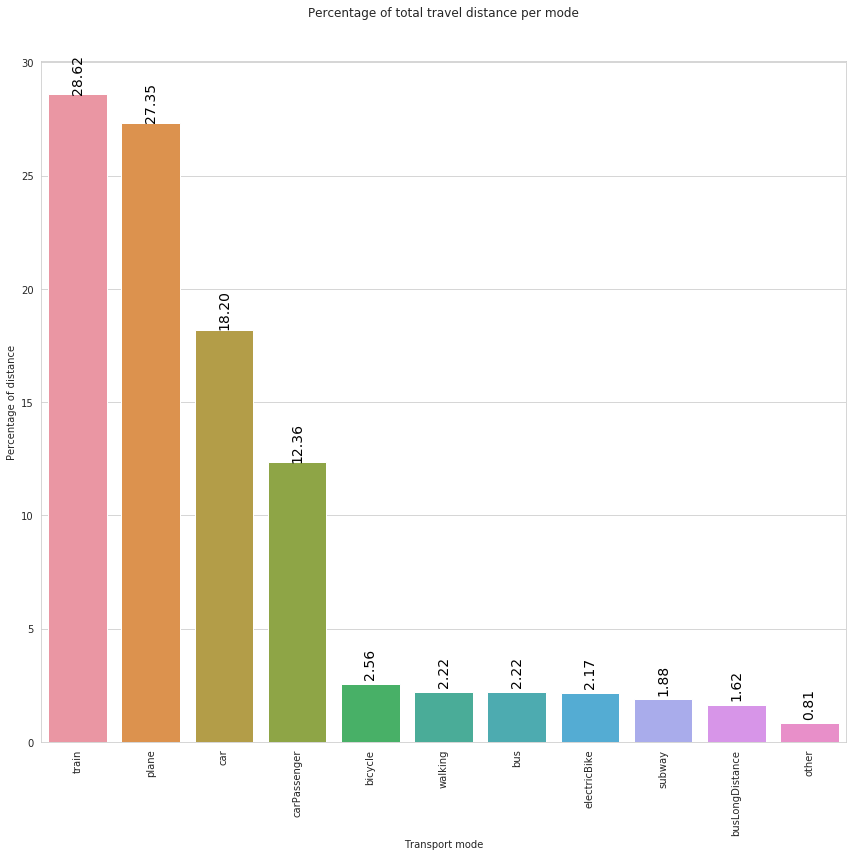

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")


g = sns.barplot(data = transport_mode_share, x="transportMode", y='frel').set(
    xlabel='Transport mode', 
    ylabel = 'Percentage of distance'
)


# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of total travel distance per mode', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

In the above plot we can observe that, during the analyzed 1-day period, the most used transport mode in terms of distance is the train, followed by plane and car.

### Worthwhileness satisfaction

- The corresponding variable is **`wastedTime`**;
- The Worthwhileness satisfaction value must be a value between 1 and 5, so any other value not in this range must be considered an error and discarded

In [0]:
#Check if there are values that are not in the correct range
legs_df['wastedTime'].unique()

array([-1,  5,  4,  3,  2,  1,  0,  6])

In [0]:
# filter out legs with an incorrect value of wastedTime
legs_df_wast = legs_df[legs_df['wastedTime'].isin([1,2,3,4,5])]
print(legs_df_wast['wastedTime'].unique())

# compute the wastedTime mean by transport mode
wasted_x_transp = legs_df_wast.groupby('ModeOfTransport')['wastedTime'].mean().reset_index()
wasted_x_transp.sort_values(by='wastedTime', ascending=False, inplace=True)
wasted_x_transp.head()

[5 4 3 2 1]


,ModeOfTransport,wastedTime
8,motorcycle,5.00
5,electricBike,4.50
12,train,4.18
13,walking,4.14
1,bikeSharing,4.00


- As before, group all train types in "Train"

In [0]:
# use aplly function to loop through all rows of the dataframe
wasted_x_transp['ModeOfTransport'] = wasted_x_transp.apply(lambda x: "train" if x['ModeOfTransport'] in (['intercityTrain','highSpeedTrain']) else x['ModeOfTransport'], axis=1)
wasted_x_transp = wasted_x_transp.groupby('ModeOfTransport').mean().reset_index().sort_values('wastedTime', ascending=False)
wasted_x_transp.head()

,ModeOfTransport,wastedTime
6,motorcycle,5.00
5,electricBike,4.50
11,walking,4.14
10,train,4.06
1,bikeSharing,4.00


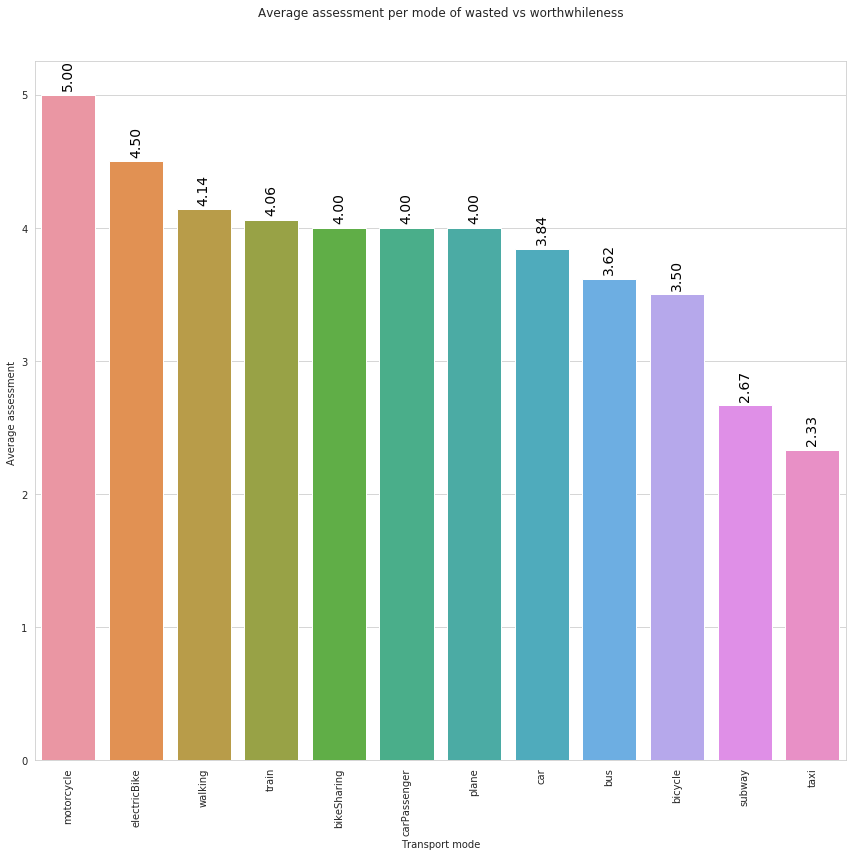

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")

g = sns.barplot(data = wasted_x_transp, x="ModeOfTransport", y='wastedTime').set(
    xlabel='Transport mode', 
    ylabel = 'Average assessment '
)


plt.title('Average assessment per mode of wasted vs worthwhileness', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

In the above plot we can observe that, during the analyzed 1-day period, users reported as the most worthwhile transport mode motocycle, followed by electricbike and walking. Of course, these values are not exhaustive and reliable since, from one hand they are based only on 1-day sample, on the other hand we are not considering the number of trips/legs per mode. This means, for instance, that if we have one travel performed by `motocycle` with `wastedTime=5`, and let's say 5 trips performed by car with the following values for `wastedTime = [5,5,5,5,4]`, motocycle will have a higher score than car even if we don't have enough information to evaluate if motocycle is really more worthwhile than car.

### Percentage mode share counting only the longest “main mode” based on distance

In [0]:
legs_df.head()

# Select only leg of type "Leg" not transfer (WaitingTime)
legs_df_1 = legs_df[legs_df['class'] == 'Leg']
print(legs_df.shape)
print(legs_df_1.shape)


# Add a ranking to each leg within the corresponding trip, based on distances (cumcount function)

legs_df_1 = legs_df_1.sort_values(['tripid', 'legDistance'], ascending=[True, False])
legs_df_1['rank'] = legs_df_1.groupby(['tripid']).cumcount()+1; 


legs_df_1.head()[['tripid','legDistance','ModeOfTransport','rank']] # Select just these columns for a better visualization





(507, 16)
(507, 16)


,tripid,legDistance,ModeOfTransport,rank
2,#30:3129,26264.00,train,1
1,#30:3129,3922.00,bus,2
70,#30:3131,2580.00,bicycle,1
69,#30:3131,952.00,bicycle,2
53,#30:3134,833.00,walking,1


Select only the longest legs (rank==1)

In [0]:
longest_legs = legs_df_1[legs_df_1['rank'] == 1]

# Check: We selected onle leg per trip (the longest one). So, we expect the number of legs
# to be equal to the number of trips.
print('Is the number of legs equal to the number of trips? ' , len(longest_legs['legid'].unique()) == len(longest_legs['tripid'].unique()) )
print('------------- ------------- ------------- ------------- -------------')
longest_legs.head(3)

Is the number of legs equal to the number of trips?  True
------------- ------------- ------------- ------------- -------------


,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time,up_bound_dist,rank
2,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train,65.47,53033.75,1
70,#30:3131,#23:7525,Leg,9.65,1.00,2580.00,1559885937507,1559886907422,-1,98RrGdM2ZCfgSOSEoImUXE91PiX2,2019-06-07 05:38:57.507,2019-06-07 05:55:07.422,16.10,bicycle,29.59,5781.33,1
53,#30:3134,#24:7500,Leg,8.51,7.00,833.00,1559883461163,1559883813731,3,XYeosrLCLohPhv9G10AE1OIvW8V2,2019-06-07 04:57:41.163,2019-06-07 05:03:33.731,5.52,walking,19.40,1540.10,1


In [0]:
# compute relative frequency by transport mode
longest_transport_mode_share = longest_legs.groupby('ModeOfTransport')['legid'].size().reset_index().sort_values(by='legid', ascending=False)
longest_transport_mode_share.columns = ['transportMode', '#legs']

# multiply by 100 to obtain percentage
longest_transport_mode_share['frel'] = longest_transport_mode_share['#legs']/longest_transport_mode_share['#legs'].sum()*100

#Check if sum of frel == 100
print(longest_transport_mode_share['frel'].sum())
longest_transport_mode_share.head()

100.0


,transportMode,#legs,frel
15,walking,65,28.14
4,car,57,24.68
0,bicycle,29,12.55
13,train,20,8.66
2,bus,19,8.23


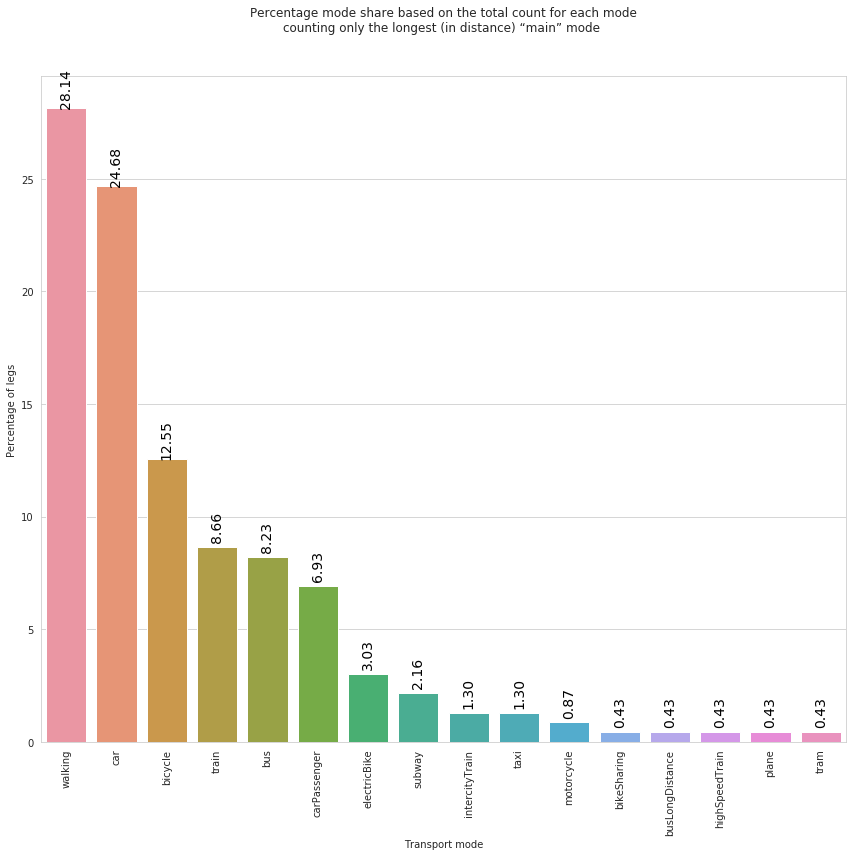

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,8

g = sns.barplot(data = longest_transport_mode_share, x="transportMode", y='frel').set(
    xlabel='Transport mode', 
    ylabel = 'Percentage of legs'
)


plt.title('Percentage mode share based on the total count for each mode\ncounting only the longest (in distance) “main” mode ', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()



Remember, a trip may be composed of multiple legs. The above plot consider only the longest leg of each trip a report the corresponding mode share. We can observe that, during the analyzed 1-day period, walking and car are the 'stand-out' winner.

### Exercise 2: 

**Percentage mode share counting only the longest “main mode” based on duration (variable *duration_min*)**


In [0]:
# PUT YOUR CODE HERE

# Select only leg of type "Leg" not transfer (WaitingTime)
#legs_df_1 = ...


# Add a ranking to each leg within the corresponding trip, based on distances






(507, 16)
(507, 16)


,tripid,duration_min,ModeOfTransport,rank
2,#30:3129,21.20,train,1
1,#30:3129,8.12,bus,2
70,#30:3131,16.10,bicycle,1
69,#30:3131,8.28,bicycle,2
53,#30:3134,5.52,walking,1


In [0]:
#select longets legs

# PUT YOUR CODE HERE
# longest_legs = ....

# Check: We selected onle leg per trip (the longest one). So, we expect the number of legs
# to be equal to the number of trips.



In [0]:
# PUT YOUR CODE HERE

# compute frequency by transport mode

#longest_transport_mode_share = ...



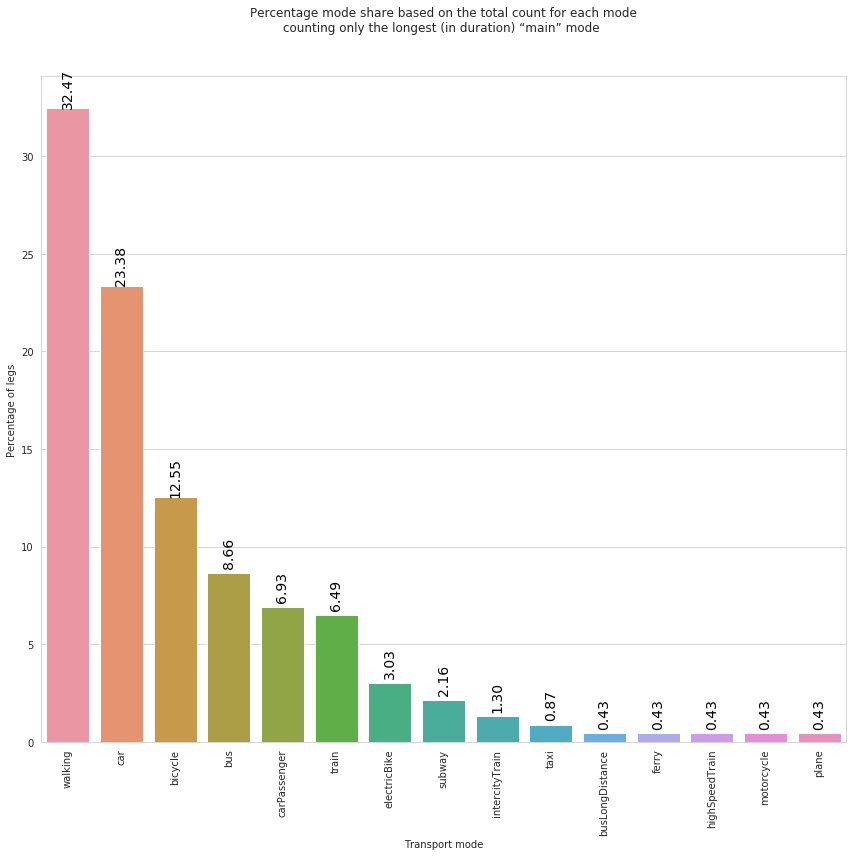

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,8

g = sns.barplot(data = longest_transport_mode_share, x="transportMode", y='frel').set(
    xlabel='Transport mode', 
    ylabel = 'Percentage of legs'
)


plt.title('Percentage mode share based on the total count for each mode\ncounting only the longest (in duration) “main” mode ', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()




### Experience Factors

#### Experience factor associated to each leg

In [0]:
#factors_url="https://www.dropbox.com/s/dnz7l1f0s0f9xun/all_factors1.pkl?dl=1"

#s=requests.get(factors_url).content
#factors_df=pd.read_pickle(io.BytesIO(s), compression=None)

# show sample of factor dataframe
factors_df.head()


,tripid,legid,factor,minus,plus
38373,#33:3216,#22:7937,Simplicity/difficulty of the route,False,True
38374,#33:3216,#22:7937,Parking at end points,False,True
38375,#33:3216,#22:7937,Ability to do what I want while I travel,False,True
38376,#33:3216,#22:7937,Road quality/vehicle ride smoothness,False,True
38377,#33:3112,#24:7646,Ability to do what I want while I travel,False,True


#### Top-10 most frequent factors reported by users

In [0]:
# for each factor compute how many times has been reported by users and select the top-10
factors_df_freq = factors_df.groupby('factor').size().reset_index()
factors_df_freq.columns = ['factor', 'count']
factors_df_freq.sort_values('count', ascending=False, inplace=True)
top_10_factors = factors_df_freq.head(10)
top_10_factors

,factor,count
40,Simplicity/difficulty of the route,113
43,Today’s weather,91
1,Ability to do what I want while I travel,87
21,Nature and scenery,49
22,Noise level,47
25,Other people,41
32,Road/path availability and safety,41
18,Information and signs,40
35,Route planning/navigation tools,40
30,Reliability of travel time,40


The experience factors shown above are the most frequent; anyway it is relevant to take into account that each experience factor can affect positively (plus=true) or negatively (minus=true) the user trip

### Top-10 most frequent experience factors that affect negatively user trips


In [0]:
# Select factors that have been reported to affect negatively user trip (minus==True)
minus_factors = factors_df[factors_df['minus'] == True]
print(minus_factors.shape)
minus_factors.head(3)



(216, 5)


,tripid,legid,factor,minus,plus
38379,#31:3125,#24:7522,Road/path availability and safety,True,True
38380,#31:3125,#24:7522,"Good accessibility (lifts, ramps, etc.)",True,True
38382,#31:3125,#24:7522,Route planning/navigation tools,True,False


In [0]:
# Compute frequency of negative factors
minus_factors_df_freq = minus_factors.groupby('factor').size().reset_index()
minus_factors_df_freq.columns = ['minus_factor', 'count']
minus_factors_df_freq.sort_values('count', ascending=False, inplace=True)
top_10_minus_factors = minus_factors_df_freq.head(10)
top_10_minus_factors['frel'] = top_10_minus_factors['count']/top_10_minus_factors['count'].sum()
top_10_minus_factors

,minus_factor,count,frel
7,Cars/other vehicles,17,0.18
21,Noise level,13,0.14
37,Simplicity/difficulty of the route,11,0.12
27,Reliability of travel time,10,0.11
23,Other people,8,0.09
3,Air quality,8,0.09
40,Today’s weather,7,0.08
29,Road/path availability and safety,7,0.08
16,"Good accessibility (lifts, ramps, etc.)",6,0.06
43,Traffic signals/crossings,6,0.06


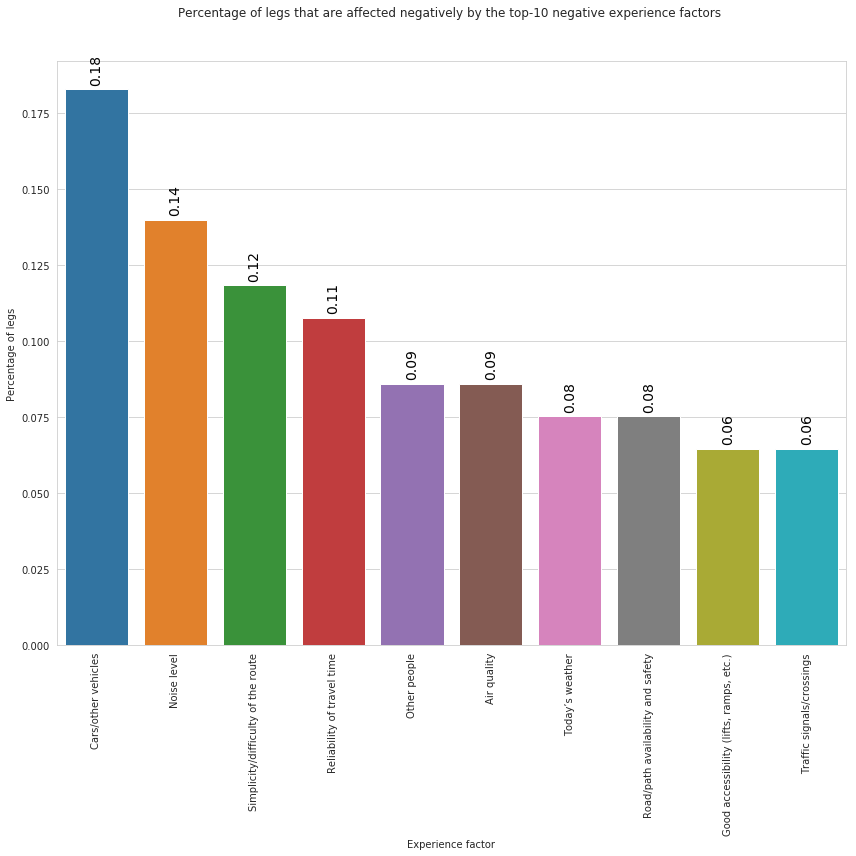

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,8

g = sns.barplot(data = top_10_minus_factors, x="minus_factor", y='frel').set(
    xlabel='Experience factor', 
    ylabel = 'Percentage of legs'
)


plt.title('Percentage of legs that are affected negatively by the top-10 negative experience factors ', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()





In the above plot we can observe that, the factor that affects negatively users' trips is the presence of other cars and vehicles follwoed by noise and Simplicity/difficulty of the route.

### Exercise 3: Top-10 most frequent experience factors that affect positively user trips

In [0]:
# From factor_df select only factors that affect positively (plus==True)
# PUT YOUR CODE HERE


#plus_factors = ...




(808, 5)


,tripid,legid,factor,minus,plus
38373,#33:3216,#22:7937,Simplicity/difficulty of the route,False,True
38374,#33:3216,#22:7937,Parking at end points,False,True
38375,#33:3216,#22:7937,Ability to do what I want while I travel,False,True


In [0]:
# Compute frequany of each factor and select top-10
# PUT YOUR CODE HERE







,plus_factor,count,frel
1,Ability to do what I want while I travel,84,0.19
39,Simplicity/difficulty of the route,77,0.18
42,Today’s weather,67,0.15
21,Nature and scenery,34,0.08
32,Road/path availability and safety,34,0.08
22,Noise level,31,0.07
34,Road/path quality,30,0.07
30,Reliability of travel time,30,0.07
25,Other people,26,0.06
18,Information and signs,25,0.06


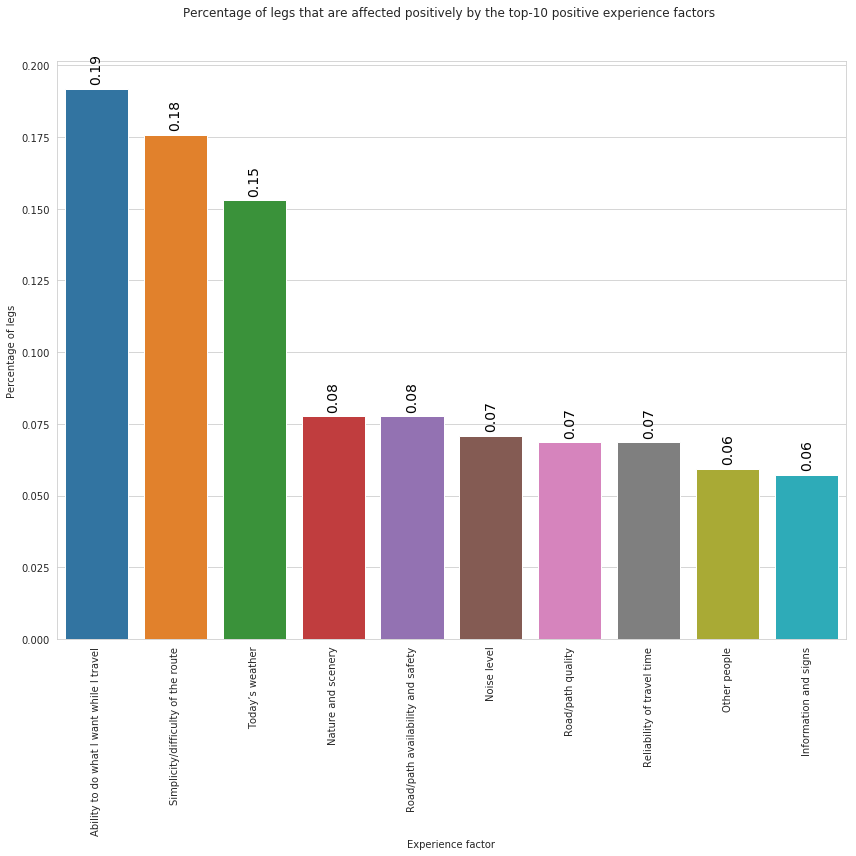

In [0]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,8

g = sns.barplot(data = top_10_plus_factors, x="plus_factor", y='frel').set(
    xlabel='Experience factor', 
    ylabel = 'Percentage of legs'
)


plt.title('Percentage of legs that are affected positively by the top-10 positive experience factors ', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()






In the above plot we can observe that, the factor that affects positively users' trips is the ability to do waht the traveller wants followed by Simplicuty/difficulty of the route and the weather conditions.

### Exercise: Analyse experience factors by gender

#### To simplify the analysis let's create a new dataframe containing information of legs, users and experience factors.

Tips: 
- You will create the new dataframe as result of the merge among the following dataframes `factors_df`, `legs_df` and `users_df`.
- Use the pandas function [pd.merge(df_1, df_2, on='column', how='left')](https://colab.research.google.com/drive/17RewF7cjd3jMCllHAt0vVMaxC2YikphL#scrollTo=cTYUJUaEqYle). 

  (Here, an [example](https://colab.research.google.com/drive/17RewF7cjd3jMCllHAt0vVMaxC2YikphL#scrollTo=DyelqmF_BemU))
- Consider that the master table (dataframe) is `factors_df` since we want to consider only legs with experience factors. In `factors_df` the same leg may be repeated multiple times.
- Create the new dataframe in 2 steps and after each step check if the result is what you expect:
  - Consider that after the pre-processing the `legs_df` dataset contains less legs that `factors_df`.
  - create a dataframe `legs_temp` as the result of the **merge between `factors_df` and `legs_df`**;
  - From `legs_temp` remove records where the information of the leg is missing : 
  
  **`legs_temp = legs_temp[~legs_temp['up_bound_dist'].isnull()]`**
  
  We decided to use `up_bound_dist` column just becouse we are sure that this column has not `null` values in the `legs_df` dataframe, other columns could be used.
  - Perform the last **merge between `legs_temp` and `users_df`** datasets.


In [0]:


# PUT YOUR CODE HERE
#legs_df_complete_temp = pd.merge( ...

 # Remove records where the information of the leg is missing :

 # PUT YOUR CODE HERE
#legs_df_complete_temp = ...
#print(legs_df_complete_temp.shape)


# PUT YOUR CODE HERE
#legs_df_complete = pd.merge(...


#legs_df_complete.head(3)



(1237, 5)
(1237, 20)
(1008, 20)
(1008, 23)


,tripid_x,legid,factor,minus,plus,tripid_y,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time,up_bound_dist,country,gender,labourStatus
0,#33:3216,#22:7937,Simplicity/difficulty of the route,False,True,#33:3216,Leg,36.23,9.00,3791.00,1559878993637.00,1559879370396.00,5.00,L93gcTzlEeMm8GwXiSK3TDEsvJJ3,2019-06-07 03:43:13.637,2019-06-07 03:49:30.396,6.17,car,59.64,37710.00,SVK,Male,Student
1,#33:3216,#22:7937,Parking at end points,False,True,#33:3216,Leg,36.23,9.00,3791.00,1559878993637.00,1559879370396.00,5.00,L93gcTzlEeMm8GwXiSK3TDEsvJJ3,2019-06-07 03:43:13.637,2019-06-07 03:49:30.396,6.17,car,59.64,37710.00,SVK,Male,Student
2,#33:3216,#22:7937,Ability to do what I want while I travel,False,True,#33:3216,Leg,36.23,9.00,3791.00,1559878993637.00,1559879370396.00,5.00,L93gcTzlEeMm8GwXiSK3TDEsvJJ3,2019-06-07 03:43:13.637,2019-06-07 03:49:30.396,6.17,car,59.64,37710.00,SVK,Male,Student


In [0]:
legs_df_complete[legs_df_complete['up_bound_dist'].isnull()].shape


(0, 23)

#### Gender distribution

In [0]:
gender_dist = legs_df_complete.groupby('gender').size().reset_index()
gender_dist.columns = ['gender', 'count']
gender_dist['frel'] = gender_dist['count']/gender_dist['count'].sum()
gender_dist


,gender,count,frel
0,Female,487,0.48
1,Male,521,0.52


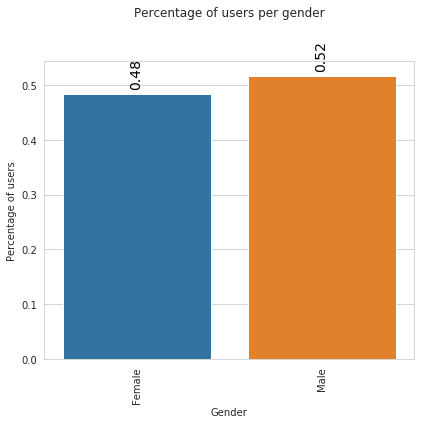

In [0]:
# plot gender distribution
fig = plt.figure(figsize=(6,6))
ax = plt.gca()


sns.set_style("whitegrid")


g = sns.barplot(data = gender_dist, x="gender", y='frel').set(
    xlabel='Gender', 
    ylabel = 'Percentage of users'
)


plt.title('Percentage of users per gender', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()







### Top-10 most frequent experience factors by gender

In [0]:
legs_df_complete.head(3)

#top-10 most frequent experience factors (positive and negative)
top_10_factors = legs_df_complete.groupby('factor').size().reset_index()
top_10_factors.columns = ['factor', 'count']
top_10_factors.sort_values('count', ascending=False, inplace=True)
top_10_factors = top_10_factors.head(10)
top_10_factors

,factor,count
40,Simplicity/difficulty of the route,91
43,Today’s weather,77
1,Ability to do what I want while I travel,71
22,Noise level,38
21,Nature and scenery,37
25,Other people,34
35,Route planning/navigation tools,33
30,Reliability of travel time,33
18,Information and signs,32
32,Road/path availability and safety,28


Notice that the above list of top-10 most reported experience factors differs from that previously computed since before we considered all reported factors, i.e., all factors in the original `legs_df` dataframe, while now we are only considering factors of the `legs_df` after the post-procecssing phase.

In [0]:
#top_10_factors['count'].sum()

Filter out legs that do not have any of the top-10 experience factor

In [0]:
print(legs_df_complete.shape)
legs_df_complete_top_factors = legs_df_complete[legs_df_complete['factor'].isin(top_10_factors['factor'])]
print(legs_df_complete_top_factors.shape)

(1008, 23)
(474, 23)


In [0]:
factors_gender = legs_df_complete_top_factors.groupby(['factor','gender' ]).size().reset_index()
factors_gender.columns = ['factor', 'gender', 'count']
factors_gender.head(4)

,factor,gender,count
0,Ability to do what I want while I travel,Female,30
1,Ability to do what I want while I travel,Male,41
2,Information and signs,Female,17
3,Information and signs,Male,15


In [0]:
#compute gender distribution
fact_gend_dist = factors_gender.groupby('gender')['count'].sum().reset_index()
fact_gend_dist.columns = ['gender', 'total_count']
fact_gend_dist


,gender,total_count
0,Female,219
1,Male,255


In [0]:
# compute relative freq of each factor in the top-10 by gender
factors_gender = pd.merge(factors_gender, fact_gend_dist, on='gender', how='left')
factors_gender.head(4)





,factor,gender,count,total_count
0,Ability to do what I want while I travel,Female,30,219
1,Ability to do what I want while I travel,Male,41,255
2,Information and signs,Female,17,219
3,Information and signs,Male,15,255


In [0]:
factors_gender['frel'] = factors_gender['count']/factors_gender['total_count']
factors_gender.head(4)

,factor,gender,count,total_count,frel
0,Ability to do what I want while I travel,Female,30,219,0.14
1,Ability to do what I want while I travel,Male,41,255,0.16
2,Information and signs,Female,17,219,0.08
3,Information and signs,Male,15,255,0.06


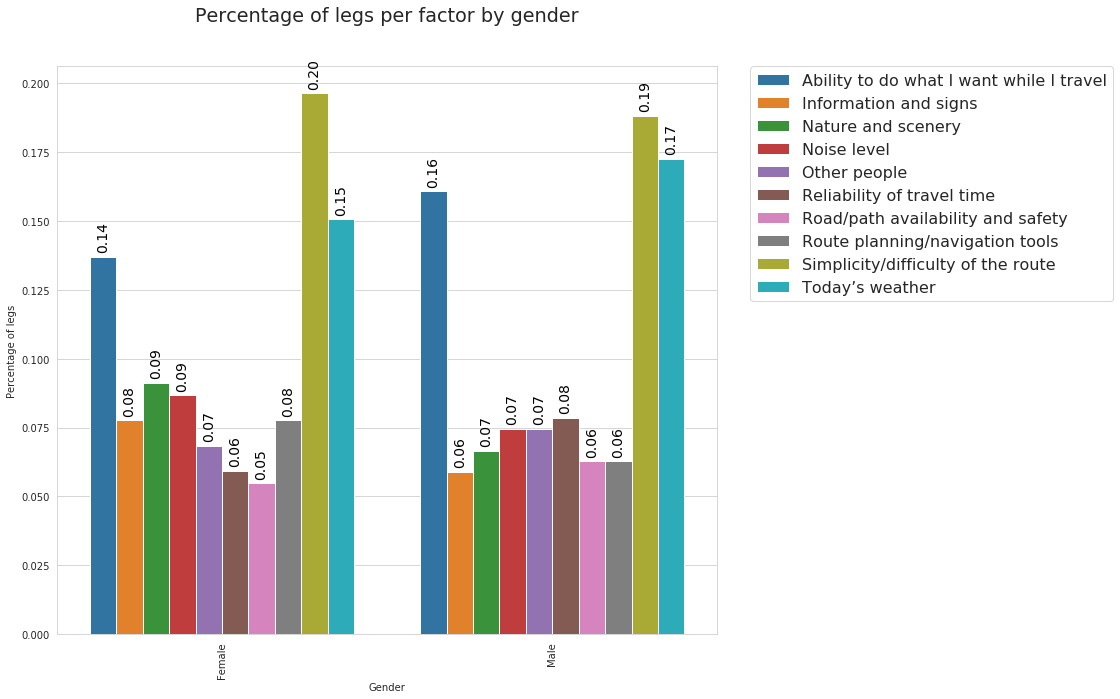

In [0]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()

rcParams['font.size'] = 16
sns.set_style("whitegrid")
# rcParams['figure.figsize'] = 16,8

g = sns.barplot(data = factors_gender, x="gender", y='frel', hue='factor').set(
    xlabel='Gender', 
    ylabel = 'Percentage of legs'
)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of legs per factor by gender', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

From the above plotwe can observe similar patterns in the factors reported by male and females. Indeed, in both cases, the most reported factor is "Simplicity/difficulty of the route" followed by "Today's weather" and "Ability to do what I want while I travel".

Note that in the above plot we use the **`hue`** parameter. It allows to  define subsets of the data, which will be drawn on separate facets.

### Exercise 4: explore distribution of Top-2 experience factors in each country


Tips:
- Similar at what we have done above with gender.
- Use he `legs_df_complete` dataset already created.
- The column for the country is `country`.

In [0]:


#top-2 most frequent experience factors (positive and negative)

# PUT YOUR CODE HERE
#top_2_factors = ...








,factor,count
40,Simplicity/difficulty of the route,91
43,Today’s weather,77


In [0]:
## From legs_df_complete select legs having factors in top_2_factors

# PUT YOUR CODE HERE
#legs_df_complete_top_factors = ...


In [0]:
# PUT YOUR CODE HERE
#factors_country = legs_df_complete_top_factors.groupby(...








In [0]:
#Compute distribution of 2 factors by country

# PUT YOUR CODE HERE
#fact_country_dist = ...







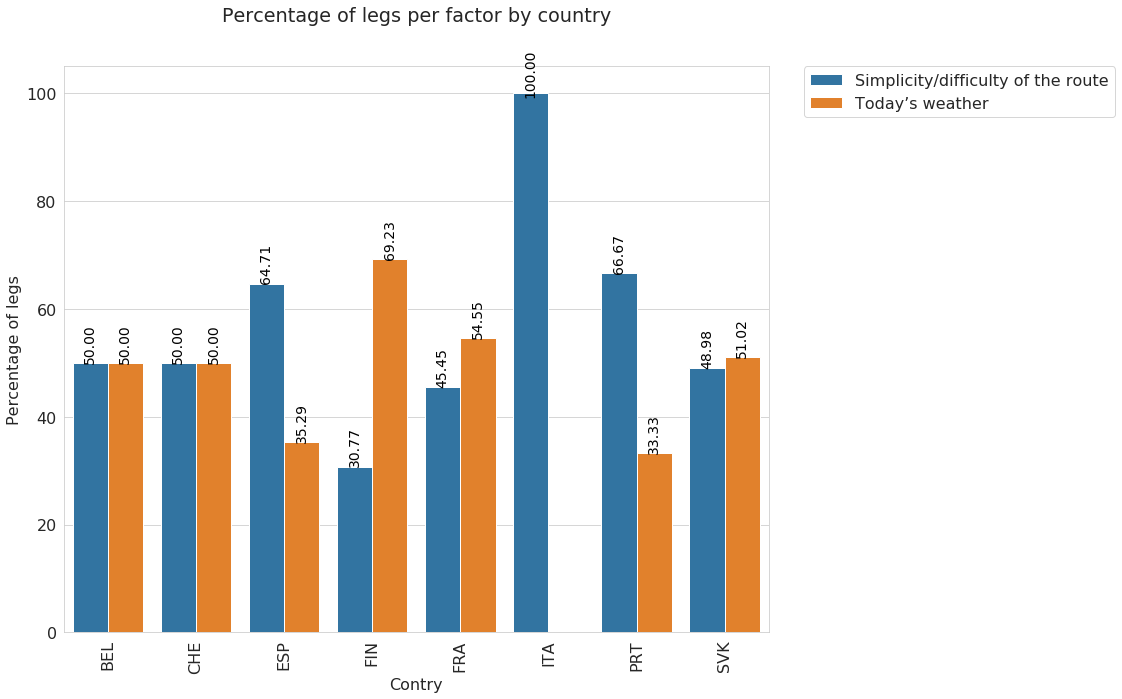

In [0]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()

rcParams['font.size'] = 16
sns.set_style("whitegrid")
# rcParams['figure.figsize'] = 16,8

g = sns.barplot(data = factors_country, x="country", y='frel', hue='factor').set(
    xlabel='Contry', 
    ylabel = 'Percentage of legs'
)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of legs per factor by country', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

From the above plot different patterns for different cities. Interesting the case of Italy where Today's weather has not been reported at all. 

Again, it is important to remember that the analysis we are performing is based on o very limited sample of data so these results are not exhaustive and informative (Our goal here is to show how these data could be explored and analyzed).

### Exercise 5: Analyze which experience factors affect negatively females' trips

Tips:
- From all legs (`legs_df_complete`) select only legs where gender attribute is *Female*
- Select top-5 factors that affect negatively (`minus=True`) Females's legs.
- Plot percentage of legs per factor


In [0]:
# Select legs with gender==female and minus=true from legs_df_complete

# PUT YOUR CODE HERE
#legs_df_complete_f = legs_df_complete[...








In [0]:
# compute frequency

# PUT YOUR CODE HERE
# top_neg_fact_fem = ...

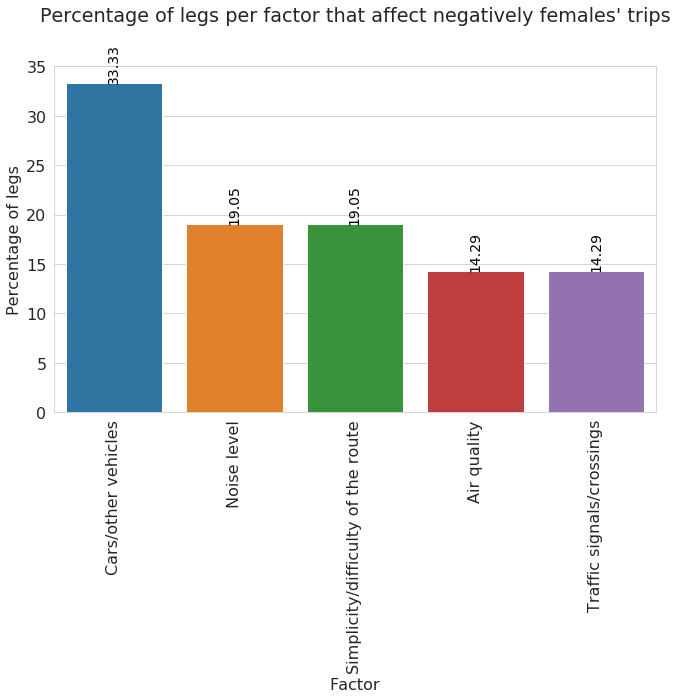

In [0]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

rcParams['font.size'] = 16
sns.set_style("whitegrid")


g = sns.barplot(data = top_neg_fact_fem, x="factor", y='perc').set(
    xlabel='Factor', 
    ylabel = 'Percentage of legs'
)

plt.xticks(rotation=90)
plt.title('Percentage of legs per factor that affect negatively females\' trips', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

An importan aspect when analyzing user mobility is the time variable.

### Time distribution of Top-5 most frequent experience factors that affect negatively females' trips

Tips:
- In this case we do not want to count the number of legs but we are interested on the total time. for each factor.
- Group by `factor` and use the function **`sum()`**

In [0]:
# Notice: For each factor we are computing the sum of the duration_min column
top_time_neg_fact_fem = legs_df_complete_f.groupby('factor')['duration_min'].sum().reset_index()
top_time_neg_fact_fem.columns = ['factor', 'tot_time']
top_time_neg_fact_fem.sort_values('tot_time',ascending=False, inplace=True)

# Select top-5
top_time_neg_fact_fem = top_time_neg_fact_fem.head(5)
top_time_neg_fact_fem['perc'] = top_time_neg_fact_fem['tot_time']/top_time_neg_fact_fem['tot_time'].sum()*100
top_time_neg_fact_fem

,factor,tot_time,perc
4,Cars/other vehicles,152.73,24.85
9,Information and signs,126.38,20.56
17,Seating quality/personal space,117.24,19.08
5,Charging opportunity,110.36,17.96
2,Air quality,107.83,17.55


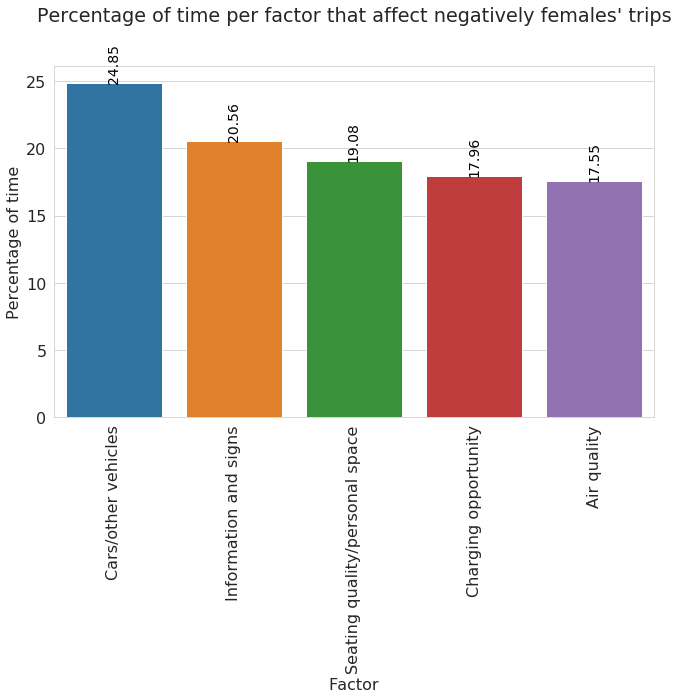

In [0]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

rcParams['font.size'] = 16
sns.set_style("whitegrid")


g = sns.barplot(data = top_time_neg_fact_fem, x="factor", y='perc').set(
    xlabel='Factor', 
    ylabel = 'Percentage of time'
)

plt.xticks(rotation=90)
plt.title('Percentage of time per factor that affect negatively females\' trips', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

The above plot reports the percentage of time per factor, considering factors that affect negatively females'trip. We can observe that "Car/other vehicles" and "Information and signs" are the most reported factors in this context.

### Exercise 6: Analize the percentage of time of the top-5 factors for car legs

Tips:
- From all legs select only legs performed by car
- Select top-5 factors that affect positively (plus=True) and negatively (minus=True) car legs and store them in 2 different dataframes.
- Plot percentage of legs per factor

In [0]:
# PUT YOUR CODE HERE
#car_legs_plus = ...
#car_legs_minus = ...



In [0]:
# Compute frequency of positive factors

# PUT YOUR CODE HERE
#plus_factor_min = 







In [0]:
# Compute frequency of negative factors

# PUT YOUR CODE HERE
# minus_factor_min = ....


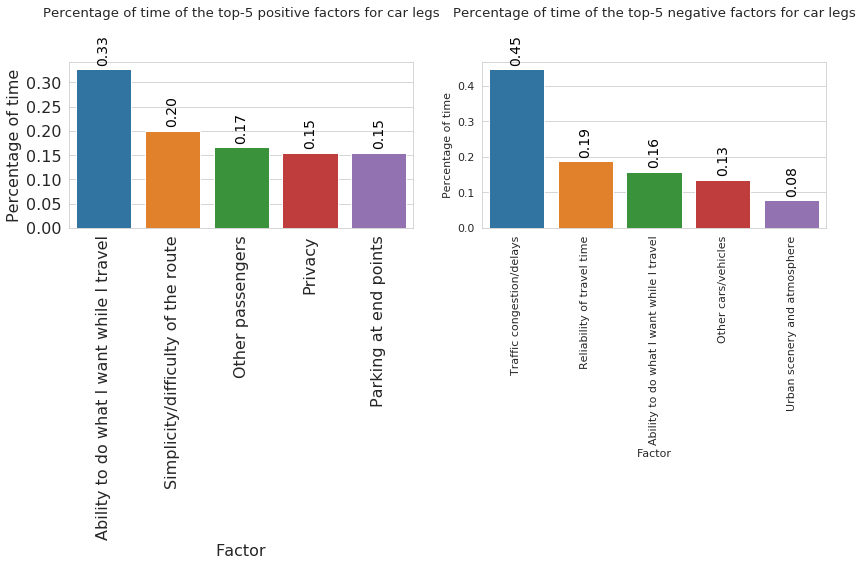

In [0]:
# Generate two plot in 1 figure
#subplot(nrows, ncols, index of plot)

plt.subplot(1, 2, 1) # grid of 1 row, 2 column and put next plot in position 1

ax = plt.gca()

rcParams['font.size'] = 11
sns.set_style("whitegrid")


g = sns.barplot(data = plus_factor_min, x="factor", y='perc').set(
    xlabel='Factor', 
    ylabel = 'Percentage of time'
)

plt.xticks(rotation=90)
plt.title('Percentage of time of the top-5 positive factors for car legs', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()


plt.subplot(1, 2, 2) # grid of 1 row, 2 column and put next plot in position 2

ax = plt.gca()

rcParams['font.size'] = 11
sns.set_style("whitegrid")


g = sns.barplot(data = minus_factor_min, x="factor", y='perc').set(
    xlabel='Factor', 
    ylabel = 'Percentage of time'
)

plt.xticks(rotation=90)
plt.title('Percentage of time of the top-5 negative factors for car legs', y=1.)

for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

plt.tight_layout()

In the above plots we can observe respectively the factors the affect positively and negatively trips perfmed by car. As positive factors, the most reported are "Ability to do what I want while I travel" and "Simplicity/Difficulty of the route". On the other side the factors that affect negatively car's trip are "Traffic congestion/ delays" and "Reliability of travel time".

### Analyze Worthwhileness satisfaction by transport mode and country

- Consider top-5 transport modes
- Consider top-5 transport countries

In [0]:
legs_df_user = pd.merge(legs_df, users_df, on='userid', how='left')
legs_df_user.head(3)

,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time,up_bound_dist,country,gender,labourStatus
0,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12,bus,39.17,10602.75,SVK,Male,-
1,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train,65.47,53033.75,SVK,Male,-
2,#33:3216,#22:7937,Leg,36.23,9.00,3791.00,1559878993637,1559879370396,5,L93gcTzlEeMm8GwXiSK3TDEsvJJ3,2019-06-07 03:43:13.637,2019-06-07 03:49:30.396,6.17,car,59.64,37710.00,SVK,Male,Student


In [0]:
# find top-5 most frequent countries
country_count = legs_df_user.groupby('country').size().reset_index()
country_count.columns = ['country','count']
country_count.sort_values('count', ascending=False, inplace=True)
country_count = country_count.head(5)
country_count

,country,count
2,ESP,125
8,SVK,124
7,PRT,70
0,BEL,56
4,FRA,44


In [0]:
# find top-5 most frequent transport modes
mode_count = legs_df_user.groupby('ModeOfTransport').size().reset_index()
mode_count.columns = ['mode','count']
mode_count.sort_values('count', ascending=False, inplace=True)
mode_count = mode_count.head(5)
mode_count

,mode,count
16,walking,221
4,car,97
0,bicycle,55
14,train,31
2,bus,30


In [0]:
# select only legs with transport mode and country that are in the respective top-5
trnsp_country_worth_temp = legs_df_user[(legs_df_user['country'].isin(country_count['country']) ) &
                                       (legs_df_user['ModeOfTransport'].isin(mode_count['mode']) )]

print(trnsp_country_worth_temp.shape)                                       
trnsp_country_worth_temp.head(3)

(354, 19)


,tripid,legid,class,averageSpeed,correctedModeOfTransport,legDistance,startDate,endDate,wastedTime,userid,startDate_formated,endDate_formated,duration_min,ModeOfTransport,up_bound_time,up_bound_dist,country,gender,labourStatus
0,#30:3129,#22:7538,Leg,28.67,15.00,3922.00,1559876476234,1559876968789,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:01:16.234,2019-06-07 03:09:28.789,8.12,bus,39.17,10602.75,SVK,Male,-
1,#30:3129,#23:7518,Leg,73.89,10.00,26264.00,1559877214732,1559878494386,-1,cc0RZphNb4ff9dCHQSSUnOKaa493,2019-06-07 03:13:34.732,2019-06-07 03:34:54.386,21.20,train,65.47,53033.75,SVK,Male,-
2,#33:3216,#22:7937,Leg,36.23,9.00,3791.00,1559878993637,1559879370396,5,L93gcTzlEeMm8GwXiSK3TDEsvJJ3,2019-06-07 03:43:13.637,2019-06-07 03:49:30.396,6.17,car,59.64,37710.00,SVK,Male,Student


In [0]:
# Remove values of wastedTime that are not in the range 1-5
trnsp_country_worth_temp = trnsp_country_worth_temp[trnsp_country_worth_temp['wastedTime'].isin([1,2,3,4,5])]
trnsp_country_worth = trnsp_country_worth_temp.groupby(['ModeOfTransport', 'country'])['wastedTime'].mean().reset_index()
trnsp_country_worth.head()

,ModeOfTransport,country,wastedTime
0,bicycle,BEL,2.75
1,bicycle,ESP,3.50
2,bicycle,FRA,4.00
3,bicycle,PRT,4.00
4,bicycle,SVK,5.00


In [0]:


# starting from the above dataframe we want toreshape data to obtain a matrix. Use PIVOT function 
# (it Reshape data, and produce a “pivot” table, based on column values.)
heat_df = trnsp_country_worth.pivot(index='ModeOfTransport', columns='country', values='wastedTime')
heat_df.sort_index(level=0, ascending=False, inplace=True)
heat_df


country,BEL,ESP,FRA,PRT,SVK
ModeOfTransport,,,,,
walking,4.50,4.00,3.50,4.30,4.36
train,5.00,3.50,nan,4.00,5.00
car,2.00,4.27,3.50,3.36,4.40
bus,1.50,3.67,nan,4.00,nan
bicycle,2.75,3.50,4.00,4.00,5.00


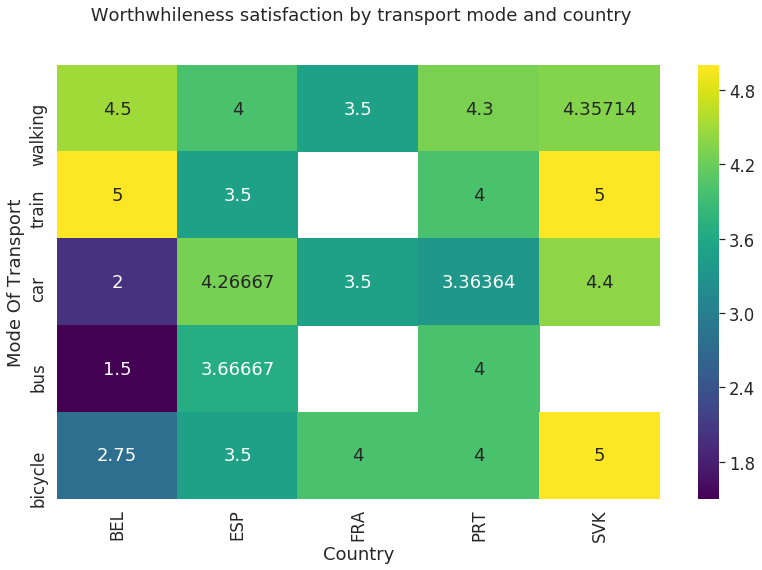

In [0]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
rcParams['figure.figsize'] = 11.7,8.27


sns.heatmap(heat_df, annot=True, fmt="g", cmap='viridis').set(
    xlabel='Country', 
    ylabel = 'Mode Of Transport'
)

# Bigger than normal fonts
plt.xticks(rotation=90) 

plt.title(' Worthwhileness satisfaction by transport mode and country',  y=1)


plt.tight_layout()
plt.show()

From the above plot we can observe that the most satisfied travelers are Slovakians when traveling by bicycle and train and Belgians when traveling by train.

## Other Tools

Mobility data may also contain geo-spatial information, i.e. the coordinates (latitude and longitude) of the starting and arrival points. 

#### Folium: Python library for the interactive visualization of geo-spatial data.


Read a toy dataset containing:
- Starting and arrival points coordinates of some legs;
- duration in seconds.


In [0]:
import pandas as pd
import io # To work with with stream (files)
import requests # library to make http requests

import folium


In [0]:
s=requests.get('https://www.dropbox.com/s/zufk87nlz216b23/coords.csv?dl=1').content
coords=pd.read_csv(io.BytesIO(s), compression=None)
coords.head(3)



,Unnamed: 0,start_long,start_lat,end_long,end_lat,duration_sec
0,0,-73.982155,40.767937,-73.964630,40.765602,455
1,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,-73.979027,40.763939,-74.005333,40.710087,2124


#### Dipslay the starting latitude and longitude of each leg

In [0]:


mymap = folium.Map(location=[coords["start_lat"].mean(), coords["start_long"].mean()], zoom_start=12 )
for each in coords[:100].iterrows():
    folium.CircleMarker([each[1]['start_lat'],each[1]['start_long']],
                        radius=3,
                        color='blue',
                        popup=str('Trip duration:\n'  + str(each[1]['duration_sec']) + ' Seconds'),
                        fill_color='#FD8A6C'
                        ).add_to(mymap)
mymap

#### Cluster the points: FastMarkerCluster



In [0]:
from folium.plugins import FastMarkerCluster

mymap = folium.Map(location=[coords["start_lat"].mean(), coords["start_long"].mean()], zoom_start=6 )
folium.TileLayer('openstreetmap').add_to(mymap)
folium.TileLayer('cartodbdark_matter').add_to(mymap)

callback = ('function (row) { var circle = L.circle(new L.LatLng(row[0], row[1],{color: \"red\", radius: 20000}));  return circle}')

FastMarkerCluster(data=list(zip(coords["start_lat"], coords["start_long"])), callback=callback).add_to(mymap)

folium.LayerControl().add_to(mymap)

mymap



### geopy library to work with coordinates and compute distances in the earth: https://pypi.org/project/geopy/


#### Compute the distance in meters of each leg

In [0]:
# geopy library to work with coordinates and compute distances in the earth: https://pypi.org/project/geopy/
from geopy.distance import geodesic

coords['distance_m'] = coords.apply(lambda x: round(geodesic((x['start_lat'], x['start_long']), (x['end_lat'], x['end_long'])).meters,2), axis=1 )
coords.head()

,Unnamed: 0,start_long,start_lat,end_long,end_lat,duration_sec,distance_m
0,0,-73.982155,40.767937,-73.964630,40.765602,455,1502.17
1,1,-73.980415,40.738564,-73.999481,40.731152,663,1808.66
2,2,-73.979027,40.763939,-74.005333,40.710087,2124,6379.69
3,3,-74.010040,40.719971,-74.012268,40.706718,429,1483.63
4,4,-73.973053,40.793209,-73.972923,40.782520,435,1187.04


#### Display starting points of each leg with a radius proportional o the length of the leg.

In [0]:
mymap = folium.Map(location=[coords["start_lat"].mean(), coords["start_long"].mean()], zoom_start=12 )
folium.TileLayer('cartodbdark_matter').add_to(mymap)
for each in coords[:100].iterrows():
    folium.CircleMarker([each[1]['start_lat'],each[1]['start_long']],
                        radius=each[1]['distance_m']/1000,
                        color='blue',
                        popup=str('Trip duration:\n'  + str(each[1]['duration_sec']) + ' Seconds'),
                        fill_color='#FD8A6C'
                        ).add_to(mymap)
mymap

### [geopandas](http://geopandas.org)
Open source project to make working with geospatial data in python easier (for instance working with shapefiles).




---


# Tutorial – Data Analysis of Mobility Behaviour Data
---



![alt text](https://eurecat.org/wp-content/uploads/2019/09/Woorti_Creative_workshop.png)


  ![alt text](https://www.jaystintandvinyl.com/wp-content/uploads/2015/10/thank-you.png)






